# Developing the GoogLeNet model with Pytorch

## Introduction

### Motivation for this notebook

**The book "Mastering Pytorch"** does not show very much about the model GoogLeNet. It gives the architecture, explains a bit of to implement it with Pytorch, but **does not give a full implementation of the model**. The definition provided in the book for the class GoogLeNet is not reusable because in the method 'forward' reference to not defined variables 'a4', 'b4', c4', ... are made

As I am curious, **I propose to give a full implementation in PyTorch (V2)**.
The training is done in this notebook by using the train module of torchvision, on the dataset ImageNet.

### A few explanations about the model

GoogLeNet is radically different of its notorious predecessors (LeNet, AlexNet, VGG, ...). It is based on the idea of **Inception modules**. Each inception modeule use **convolutions with different kernel sizes** (1x1, 3x3, 5x5) and **concatenate the results**. The idea is to **reduce the number of parameters** and **increase the number of channels**.
GoogLeNet is remarkable in the fact despite the model is very deep (22 layers) and very complex compared to its predecessors (use of inception modules, parallel branch of networks), it has a **very small number of parameters** (7 millions) compared to AlexNet (60 millions) or VGG (140 millions).

The architecture is given in the following figure:

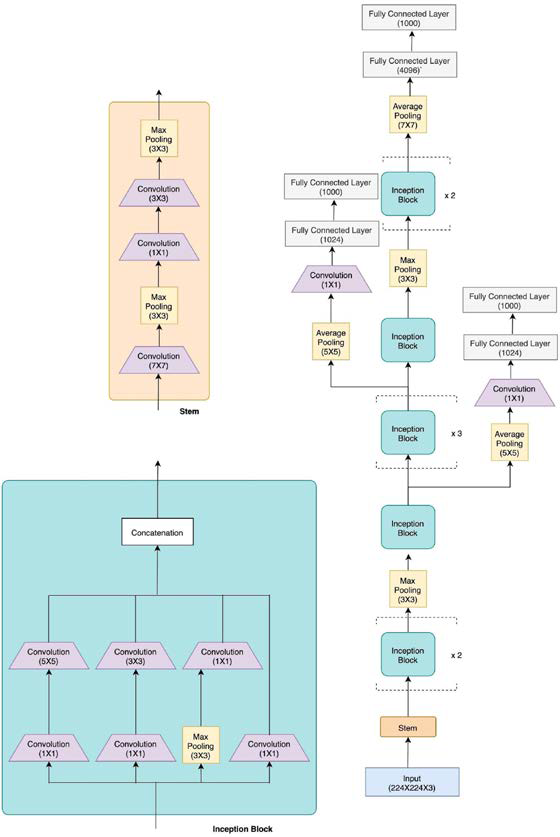

## Installation of technical requirements

On the contrary to what is done in the book, I chose to develop this model by using pytorch 2 (instead of v1.4).
This notebook is designed to be standalone, definining its own environment, to be executed with a GPU for example in Google Collab.

In [1]:
!pip install torch==2.0.1
!pip install torchvision==0.15.2
!pip install Pillow==10.0.1
!pip install pycocotools==2.0.7
!pip install matplotlib==3.8.0

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 619.9/619.9 MB 1.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.0/21.0 MB 48.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 849.3/849.3 kB 37.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.8/11.8 MB 58.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 557.1/557.1 MB 3.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.1/317.1 MB 4.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 168.4/168.4 MB 6.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.6/54.6 MB 12.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 102.6/102.6 MB 8.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 173.2/173.2 MB 6.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 177.1/177.1 MB 6.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.6/98.6 kB 12.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.6/11.6 MB 78.6 MB/s eta 0:00:00
  Attempting uninstall: matplotlib
    Found existing installation: matplotlib 3.7.1
    Uninstalling matplotlib-3.7.1:
      Successfully uninstalled matplotlib-3.7.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
lida 0.0.10 requires fastapi, which is not installed.
lida 0.0.10 requires kaleido, which is not installed.
lida 0.0.10 requires python-multipart, which is not installed.
lida 0.0.10 requires uvicorn, which is not installed.


### Importing the required packages

In [1]:
import os
import time
import copy
import numpy as np
import matplotlib.pyplot as plt

import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch import Tensor
from torch.optim import lr_scheduler
from torchvision import datasets, models, transforms

torch.manual_seed(0)

## Defining the model

As the model is quite complex, I chose to split its definition in several classes, and to use the same variable naming as in the original paper.

As a quick note on the output size of a convolutional layer, the formula is:
$$
\lfloor(n_\textrm{h}-k_\textrm{h}+p_\textrm{h}+s_\textrm{h})/s_\textrm{h}\rfloor \times \lfloor(n_\textrm{w}-k_\textrm{w}+p_\textrm{w}+s_\textrm{w})/s_\textrm{w}\rfloor
$$

Where the input size is $n_h \times n_w$, $k_h \times k_w$ is the kernel size, 
$p_h \times p_w$ is the padding size, $s_h \times s_w$ is the stride size.

In [ ]:
# Import for typing
from typing import Optional, Tuple, List, Callable, Any

# A specific class for the convolution blocks used in the Inception module, including the BatchNorm layer and Relu activation layer
class ConvBlock(nn.Module):
    def __init__(self, 
            in_channels: int, 
            out_channels: int, 
            **kwargs: Any):
        super(ConvBlock, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, bias=False, **kwargs)
        self.bn = nn.BatchNorm2d(out_channels, eps=0.001)
        
    def forward(self, x: Tensor) -> Tensor:
        x = self.conv(x)
        x = self.bn(x)
        return self.relu(x), inplace=True)

# A specific class for an Inception module
class InceptionModule(nn.Module):
    def __init__(self,
        in_channels: int,
        ch1x1: int,
        ch3x3red: int, # number of 1x1 filters (in the reduction layer) before the 3x3 convolution
        ch3x3: int,
        ch5x5red: int, # number of 1x1 filters (in the reduction layer) before the 5x5 convolution
        ch5x5: int,
        pool_proj: int) -> None:
        super(InceptionModule, self).__init__()
        self.branch1 = ConvBlock(in_channels, ch1x1, kernel_size=1)
        self.branch2 = nn.Sequential(
            ConvBlock(in_channels, ch3x3red, kernel_size=1),
            ConvBlock(ch3x3red, ch3x3, kernel_size=3, padding=1)
        )
        self.branch3 = nn.Sequential(
            ConvBlock(in_channels, ch5x5red, kernel_size=1),
            ConvBlock(ch5x5red, ch5x5, kernel_size=5, padding=2)
        )
        self.branch4 = nn.Sequential(
            nn.MaxPool2d(kernel_size=3, stride=1, padding=1, ceil_mode=True),
            ConvBlock(in_channels, pool_proj, kernel_size=1)
        )
    
    def forward(self, x: Tensor) -> Tensor:
        return torch.cat([
            self.branch1(x),
            self.branch2(x),
            self.branch3(x),
            self.branch4(x)
        ], 1)

# A specific class for the auxiliary classifier after the inception modules
class InceptionAuxClassifier(nn.Module):
    def __init__(self, in_channels: int, num_classes: int) -> None:
        super(InceptionAuxClassifier, self).__init__()
        self.conv = ConvBlock(in_channels, 128, kernel_size=1)
        self.fc1 = nn.Linear(2048, 1024)
        self.fc2 = nn.Linear(1024, num_classes)
    
    def forward(self, x: Tensor) -> Tensor:
        # At first the average pooling: for aux1, N x 512 x 14 x 14. And for aux2, N x 528 x 14 x 14
        x = F.adaptive_avg_pool2D(x, (4, 4))
        # Then the conv block: for aux1, N x 512 x 4 x 4. And for aux2, N x 528 x 4 x 4
        x = self.conv(x)
        # Then we flatten the tensor: N x 128 x 4 x 4 -> N x 2048
        x = torch.flatten(x, 1)
        # Then the activation layer on the first fully connected layer
        x = F.relu(self.fc1(x)) # N x 1024
        # Then the dropout layer
        x = F.dropout(x, 0.7, training=self.training)
        # Then the second fully connected layer
        x = self.fc2(x) # N x 1000
        return x

# Define a class for the subnet before the inception modules
# MFT: please be aware that in the book "Mastering Pytorch", the code proposed to implement this subnet is not correct
class Stem(nn.Module):
    def __init__(self, in_channels: int) -> None:
        super(Stem, self).__init__()
        # We use here ConvBlock instead of nn.Conv2d to include the BatchNorm layer and the Relu activation layer
        self.conv1 = ConvBlock(in_channels, 64, kernel_size=7, stride=2, padding=3) # (224 - 7 + 2 + 3)/2+1 = 112
        self.maxpool1 = nn.MaxPool2d(kernel_size=3, stride=2, ceil_mode=True)
        # We use here nn.Conv2d because we don't need the BatchNorm layer after the conv2
        self.conv2 = nn.Conv2d(64, 64, kernel_size=1)
        self.conv3 = nn.Conv2d(64, 192, kernel_size=3, padding=1)
        self.bn = nn.BatchNorm2d(192, eps=0.001)
        self.maxpool2 = nn.MaxPool2d(3, stride=2, ceil_mode=True)

    def forward(self, x: Tensor) -> Tensor:
        x = self.conv1(x)
        x = self.maxpool1(x)
        x = F.relu(self.conv2(x))
        x = F.relu(self.bn(self.conv3(x)))
        x = self.maxpool2(x)
        return x
    
# Define the class for the GoogLeNet model
class GoogLenet(nn.module):
    def __init__(self, num_classes: int = 1000):
        super(GoogLenet, self).__init__()
        
        # The subnet before the inception modules
        self.stem = Stem(3)
        
        # The first block with 2 inception modules
        self.inception3a = InceptionModule(192, 64, 96, 128, 16, 32, 32)
        self.inception3b = InceptionModule(256, 128, 128, 192, 32, 96, 64)
        self.maxpool3 = nn.MaxPool2d(kernel_size=3, stride=2, ceil_mode=True)

        # The second block with 5 inception modules
        self.inception4a = InceptionModule(480, 192, 96, 208, 16, 48, 64)
        self.inception4b = InceptionModule(512, 160, 112, 224, 24, 64, 64)
        self.inception4c = InceptionModule(512, 128, 128, 256, 24, 64, 64)
        self.inception4d = InceptionModule(512, 112, 144, 288, 32, 64, 64)
        self.inception4e = InceptionModule(528, 256, 160, 320, 32, 128, 128)
        self.maxpool4 = nn.MaxPool2d(kernel_size=3, stride=2, ceil_mode=True)

        # The third block with 2 inception modules
        self.inception5a = InceptionModule(832, 256, 160, 320, 32, 128, 128)
        self.inception5b = InceptionModule(832, 384, 192, 384, 48, 128, 128)

        # The auxiliary classifiers
        self.aux1 = InceptionAuxClassifier(512, num_classes)
        self.aux2 = InceptionAuxClassifier(528, num_classes)

        # The rest of the network
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.dropout = nn.Dropout(0.2)
        self.fc = nn.Linear(1024, num_classes)

        #TODO: initialize the weights of the network

    def forward(self, x: Tensor) -> Tensor:
        # The subnet before the inception modules
        x = self.stem(x)

        # The first block with 2 inception modules
        x = self.inception3a(x)
        x = self.inception3b(x)
        x = self.maxpool3(x)

        # The second block with 5 inception modules
        x = self.inception4a(x)
        # Auxiliary classifier 1
        aux1 = self.aux1(x)
        x = self.inception4b(x)
        x = self.inception4c(x)
        x = self.inception4d(x)
        # Auxiliary classifier 2
        aux2 = self.aux2(x)
        x = self.inception4e(x)
        x = self.maxpool4(x)

        # The third block with 2 inception modules
        x = self.inception5a(x)
        x = self.inception5b(x)

        # The rest of the network
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.dropout(x)
        x = self.fc(x)

        return x, aux1, aux2

## Preparing the dataset

## Defining data loaders and transformers

## Fine-tuning the model

### Loading the pre-trained model from pytorch repository


### Defining the fine-tuning procedure




### Running the fine-tunning experiment


## Saving the model

If you want to later use this fine-tuned, I advice to save the model weights with shapes to not need to instantiate the model class at first.

In [31]:
torch.save(model_finetuned, "alexnet_hymenoptera.pth")

In [32]:
# Writing a short description of the model file
model_description ="""This model is fine-tuned of the pretrained version of AlexNet available in torchvision.
It's been fine-tuned on the dataset hymeoptera available at https://www.kaggle.com/datasets/ajayrana/hymenoptera-data.
It's been fine-tuned by using a SGD optimizer with a lr=0.0001 on 9 epochs. The loss function used was the cross entropy."""
with open("alexnet_hymenoptera-description.txt", "w") as writefile:
    writefile.write(model_description)

## Save the models to your drive

In [33]:
from google.colab import drive
drive.mount("/content/drive")

model_path = "/content/drive/MyDrive/models"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
